In [93]:
import pandas as pd  #for storing and manipulating data locally
import numpy as np # for math
import datetime as dt # for dealing with time variables in the data
import matplotlib.pyplot as plt # for visualising the data
import seaborn as sns # for visualising their data

def q2url(string, endpoint = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.csv'):
    """
    This function changes a query as a string to a url that will communicate that query to the API.
    
    Removes white space and new lines from the string. 
    Use %20 to insert white space in queries.
    """
    url = endpoint + "?"+string
    url = url.replace(" ","").replace("\n","")
    return url

# Looking past seasonal trends

There are a lot of seasonal fluctuations. How would we be able to remove them? Well, the answer is linear algebra, obviously :)

The general idea is that we want to decompose the time series $u(t)$ into a periodic part $\tilde u(t)$ and it's complement $\overline u (t)$ such that $u(t) = \overline u (t) + \tilde u(t)$ and $\tilde u(t) \perp \overline u(t)$. Once we do this, $\tilde u$ is the seasonal fluctuations, and $\overline u$ is the denoised part that we would be interested in.

So let's first load in the data:

In [94]:
# request for agency data
qq = """$select=agency, date_trunc_ym(created_date)%20AS%20month, COUNT(unique_key)%20AS%20total_calls
        &$group=agency, month
        &$limit=10 000"""
#
Over_months = pd.read_csv(q2url(qq))

/Users/djkelleher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


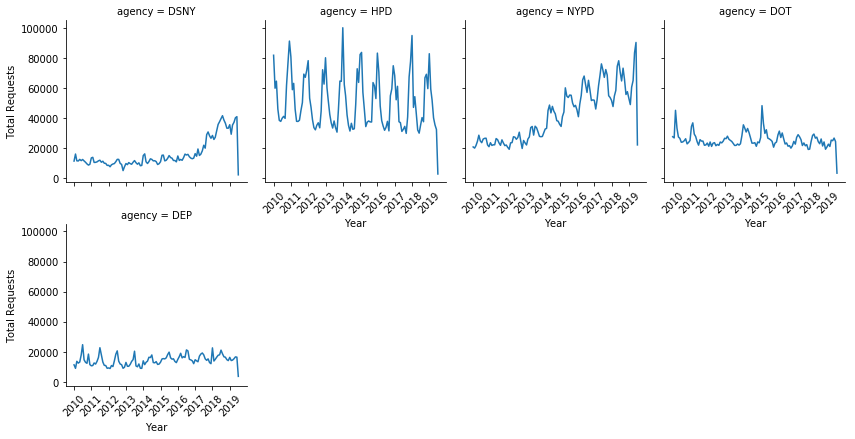

In [95]:
# List of the top agencies
departments = ['HPD', 'NYPD','DOT',  'DSNY', 'DEP']
#
# restrict to the top agencies
Over_months.month = pd.to_datetime(Over_months.month)
Over_months_agencies = Over_months[Over_months.agency.isin(departments)]
Over_months_agencies["moy"] = Over_months_agencies.month.apply(lambda x: x.month)
#
# Initialise facet grid
g = sns.FacetGrid(Over_months_agencies,
                 col = "agency", col_wrap=4) 
#
# Map lineplot
g = g.map(sns.lineplot,
                 "month", 
                 "total_calls" )
g = g.set_xticklabels(rotation = 45)
#
# Relabel the axes
g = g.set_ylabels("Total Requests")
g = g.set_xlabels("Year")

# Let's get linear algebra wonky!

Some of these are more effected by seasonal changes than others, which is good for this, because what we are doing should have a proportional effect on times series which don't have seasons.

Let's lay out the entire workflow before implementing it.

- The first step is to isolate seasonal, which is we will put into a dataframe called `seasonal`, this will be the vector $\tilde u(t)$ mentioned above. 
- After that we take the time series $u(t)$ and substract off the projection of $u(t)$ onto the span of $\tilde u(t)$.  This shall be $\overline u(t)$ above, which we will call the `adjusted_total`, as it is the total number of calls after removing seasonal flux.

## Periodic Part

Starting with the seasonal data frame:

In [158]:
#
# Initiate by removing incomplete year, 2019
seasonal = Over_months_agencies[Over_months_agencies.month.apply(lambda x: x.year < 2019)]
#
# Groupby Month of Year using sum
seasonal = seasonal.groupby(('agency','moy')).sum()
seasonal.reset_index(level = 0, inplace = True)
seasonal.reset_index(level = 0, inplace = True)
seasonal = seasonal.rename(mapper = {"total_calls":"monthly_calls"}, axis ='columns')
#
# create mean for each month
totals = seasonal.groupby('agency').mean()
totals = totals[["monthly_calls"]]
totals.reset_index(level = 0, inplace = True)
totals = totals.rename(mapper = {"monthly_calls":"monthly_mean"}, axis="columns")
#
# subtract the montly mean
seasonal = pd.merge(seasonal,totals, on="agency")
seasonal["seasonal_diff"] = seasonal.monthly_calls - seasonal.monthly_mean

/Users/djkelleher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  after removing the cwd from sys.path.


In [159]:
seasonal.head()

,moy,agency,monthly_calls,monthly_mean,seasonal_diff
0,1,DEP,123120,129852.833333,-6732.833333
1,2,DEP,110046,129852.833333,-19806.833333
2,3,DEP,122790,129852.833333,-7062.833333
3,4,DEP,124254,129852.833333,-5598.833333
4,5,DEP,139151,129852.833333,9298.166667


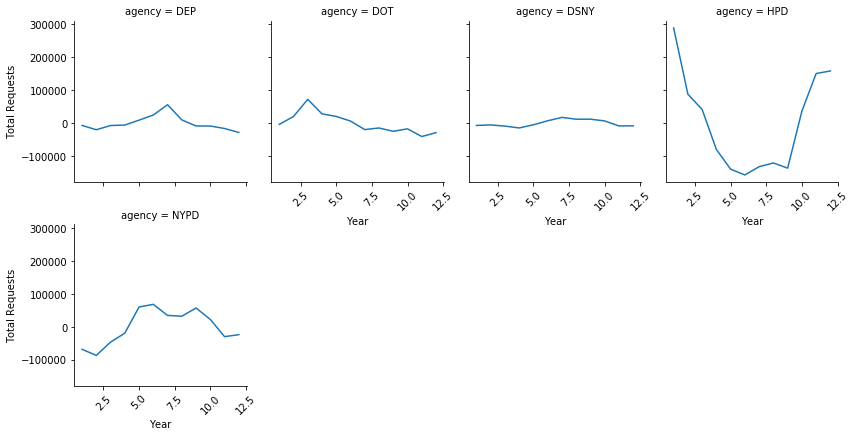

In [160]:
#
#
g = sns.FacetGrid(seasonal,
                 col = 'agency', col_wrap=4) 
#
# Map lineplot
g = g.map(sns.lineplot,
                 "moy", 
                 "seasonal_diff" )
g = g.set_xticklabels(rotation = 45)
#
# Relabel the axes
g = g.set_ylabels("Total Requests")
g = g.set_xlabels("Year")

### Notes

- I did not rescale at all, that will be handled later
- I did subtract the mean, this means that adding or subtracting a constant times this vector will not effect the total or mean of a vector.

### Observations 

You can see from this that some agencies, `NYPD` and `HPD`, which have a lot of seasonal fluctuation, but the others are pretty flat.

Finally we combine the seasonal changed into one data frame, which I have creatively titled `new_df`. 

In [171]:
new_df = pd.merge(Over_months_agencies, seasonal, on = ["moy", "agency"])

## Projection

If we have a vector $\mathbf w$, then the projection of a vector $\mathbf x$ onto the span of $\mathbf w$ is $c\cdot w$ where 
$$
c = \frac{\mathbf w \cdot \mathbf x}{\mathbf w \cdot \mathbf w}
$$
This way, if we take 
$$
(\mathbf x - c\mathbf w)\cdot \mathbf w = \mathbf x \cdot \mathbf w - \frac{\mathbf w \cdot \mathbf x}{\mathbf w \cdot \mathbf w} \mathbf w \cdot \mathbf w = 0
$$
So $\mathbf x - x\mathbf w$ is perpendicular to $\mathbf w$!

So we shall make a data frame `constants` which has the constant $c$ above for various agencies, and then merge it into `new_df`.

In [183]:
new_df['_dot'] = new_df.total_calls*new_df.seasonal_diff
new_df['_sq'] = new_df.seasonal_diff**2

constants = new_df.groupby("agency").sum()
constants['_const'] = constants._dot/constants._sq
constants.reset_index(level = 0, inplace = True)
_constants = constants[["agency","_const"]]
_constants.head()

new_df = pd.merge(new_df, _constants)

Finally we shall make our `adjusted_total` column which is defined by the projection:

In [185]:
# Make Adjusted total column
new_df['adjusted_total'] = new_df.total_calls - new_df._const*new_df.seasonal_diff

Great! We now have all of our variables set and ready to go. Let's plot them to see if we have what we want.

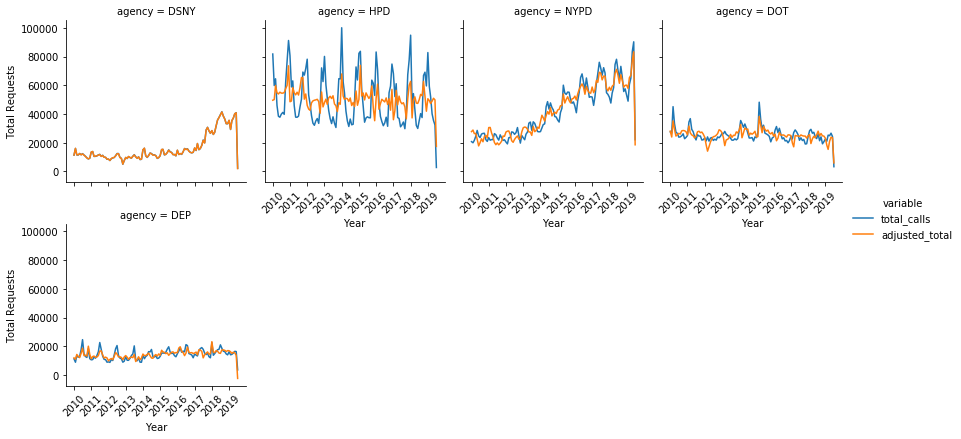

In [187]:
# Create a tidy dataframe for what we want to plot
new_df_tidy = new_df[['agency', 'month', 'total_calls', 'adjusted_total']]
new_df_tidy = new_df_tidy.rename(mapper = {'total_calls_x':'total_calls'}, axis = 'columns')
new_df_tidy = pd.melt(new_df_tidy, id_vars=('agency','month'))
#
g = sns.FacetGrid(new_df_tidy,
                 col = 'agency',  hue = 'variable', col_wrap=4) 
#
# Map lineplot
g = g.map(sns.lineplot,
                 "month", 
                 "value")
g = g.set_xticklabels(rotation = 45)
#
# Relabel the axes
g = g.set_ylabels("Total Requests")
g = g.set_xlabels("Year")
g.add_legend()

### Observations

You can see that the agencies which had a lot of seasonal variance have changed a lot. However, as you can see with `DSNY`, if there isn't much of a seasonal change, then there isn't much of an adjustment.

### Warning

There were a lot of choices here that might not be super apparent.
 - The choice to use the $\tilde u$ which sums to 0 preserves the mean, but that means it can both increase and decrease the total count.
 - The seasonal fluctuations change over time: if we look at, for example, the NYPD calls before 2014, this operation does less of a good job smoothing than after 2014. This suggests that the seasonal variations were different 2010-2014 and 2014-present.